## Approach

- use linear SGD One Class Support Vector Machine (OCSVM) to fit outlier detection model on large dataset

In [1]:
from timm.models.layers.helpers import to_2tuple
import timm
import torch.nn as nn
import torch
import torch.backends.cudnn as cudnn

from torchsummary import summary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

from sklearn.metrics import balanced_accuracy_score
from sklearn.svm import OneClassSVM
from sklearn import linear_model

import os
import pandas as pd
import openslide
from PIL import Image
import numpy as np
import random
import time
import warnings
from joblib import dump, load

from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt

import pyvips
import itertools

In [2]:
DATA_DIR = 'Data/'

args = pd.Series({
    'batch_size_per_gpu' : 2048,
    'num_workers': 4,
    'image_dir': os.path.join(DATA_DIR, 'train_images'),
    'model_name': 'CTRansPath_MLP_20x',
    'patch_df': 'train_patches_20x', 
    'mag': '20X',
})

In [3]:
device = torch.device(f'cuda' if torch.cuda.is_available() else 'cpu')    

CTransPath from https://github.com/Xiyue-Wang/TransPath

Make sure to insure specified version of timm.

In [4]:
class ConvStem(nn.Module):

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=768, norm_layer=None, 
                 flatten=True, output_fmt=None):
        super().__init__()

        assert patch_size == 4
        assert embed_dim % 8 == 0

        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.flatten = flatten


        stem = []
        input_dim, output_dim = 3, embed_dim // 8
        for l in range(2):
            stem.append(nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=2, padding=1, bias=False))
            stem.append(nn.BatchNorm2d(output_dim))
            stem.append(nn.ReLU(inplace=True))
            input_dim = output_dim
            output_dim *= 2
        stem.append(nn.Conv2d(input_dim, embed_dim, kernel_size=1))
        self.proj = nn.Sequential(*stem)

        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        #print(x.shape)
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x)
        if self.flatten:
            x = x.flatten(2).transpose(1, 2)  # BCHW -> BNC
        x = self.norm(x)
        return x

def ctranspath():
    model = timm.create_model('swin_tiny_patch4_window7_224', embed_layer=ConvStem, pretrained=False)
    return model

In [5]:
def feature_extraction(feature_model, image):
    #feature_model.eval()
    
    #image = image.cuda(non_blocking=True)
    
    with torch.no_grad():
        output = feature_model(image)
        
    return output

### Construct data loader

Load data

In [6]:
patch_df = pd.read_csv(f'{args.patch_df}.csv', index_col=0)

train_df = pd.read_csv(os.path.join(DATA_DIR, 'train_hot.csv'), index_col=0)

Using 5 classes only so -1 from class

In [7]:
train_df['label_cat'] = train_df['label_cat'] - 1

Subsample patches for WSIs

In [8]:
wsi_ids = train_df[train_df.is_tma==False].image_id.values

tma_ids = train_df[train_df.is_tma==True].image_id.values
sub_patch_df = patch_df[patch_df.image_id.isin(tma_ids)].reset_index(drop=True)

In [9]:
max_tiles = 10000

for wsi_id in wsi_ids:
    # sample min(#, 10000) tiles per WSI without replacement
    
    wsi_id_patches = patch_df[patch_df.image_id==wsi_id]
    
    if len(wsi_id_patches) > max_tiles:
        wsi_id_patches = wsi_id_patches.sample(n=max_tiles, replace=False, axis=0)
    
    # add sample to sub_patch_df
    sub_patch_df = pd.concat([sub_patch_df, wsi_id_patches], ignore_index=True)

Define transforms

In [10]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Define dataset and data loader

In [11]:
class PatchDataset(Dataset):
    def __init__(self, patch_df, label_df, image_folder, transform=None, patch_size=256, return_id=False,
                mag='10X'):
        self.patch_df = patch_df
        self.label_df = label_df
        self.image_folder = image_folder
        self.transform = transform
        self.patch_size = patch_size
        self.return_id = return_id
        self.mag = mag
        
        
    def __len__(self):
        return len(self.patch_df)
    
    
    def __getitem__(self, idx):
        patch_info = self.patch_df.loc[idx] # using loc, so using name of index not ordered position
        x, y = patch_info['x_coord'], patch_info['y_coord']
        image_id = patch_info['image_id']
        
        wsi = openslide.OpenSlide(os.path.join(self.image_folder, f"{image_id}.tif"))
        wsi_size = wsi.dimensions
        
        if self.mag == '10X':
            level = 2 if is_tma_image(image_id) else 1
        elif self.mag == '20X':
            level = 1 if is_tma_image(image_id) else 0
        else:
            level = 0
        patch = wsi.read_region((x, y), level=level, size=(self.patch_size, self.patch_size))
        patch = np.array(patch)[..., :3]
        
                
        if self.transform is not None:
            pil_img = Image.fromarray(patch)
            patch = self.transform(pil_img) # pil_img
        
        label = self.label_for_id(image_id)        
    
        if self.return_id:
            return patch, label, image_id
        else:
            return patch, label
    
        
    def label_for_id(self, image_id):
        return self.label_df[self.label_df['image_id']==image_id]['label_cat'].iloc[0]
        
def is_tma_image(image_id, label_df=train_df):
    return label_df[label_df.image_id==image_id].is_tma.item()

In [12]:
class VipsPatchDataset(Dataset):
    def __init__(self, label_df, image_folder, image_id, transform=None, rescale_factor=1, patch_size=256,
                max_patches=1000):
        self.label_df = label_df
        self.image_folder = image_folder
        self.transform = transform
        self.patch_size = patch_size
        self.level = 0
        self.image_id = image_id

        image_path = os.path.join(image_folder, f"{image_id}.png")
        pyvips_img = pyvips.Image.new_from_file(image_path, access='sequential') 
        if rescale_factor!=1:
            try:
                pyvips_img = pyvips_img.resize(rescale_factor, kernel='linear')
            except Exception:
                print('Not rescaling')
        img_np = to_numpy(pyvips_img)  
        self.tiles = tiling_predefined_patch_sample(img_np, k=max_patches) 
        
        
    def __len__(self):
        return len(self.tiles)
    
    
    def __getitem__(self, idx):
        patch = self.tiles[idx]
                
        if self.transform is not None:
            pil_img = Image.fromarray(patch)
            patch = self.transform(pil_img)
        
        if self.label_df is not None:
            label = self.label_for_id(self.image_id)
            return patch, label
        else:
            return patch, self.image_id
    
        
    def label_for_id(self, image_id):
        return self.label_df[self.label_df['image_id']==image_id]['label_cat'].iloc[0]
    
    
def to_numpy(pyvips_img): 
    return np.ndarray(
        buffer=pyvips_img.write_to_memory(),
        dtype=np.uint8,
        shape=[pyvips_img.height, pyvips_img.width, pyvips_img.bands]
    )


def tiling(image): 
    tile_size = image.shape[0] // 5 
    tiles = list()
    for i in range(5):
        for j in range(5):
            left = j * tile_size
            top = i * tile_size
            right = left + tile_size
            bottom = top + tile_size 
            tiles.append(image[top:bottom, left:right, :]) 
    return tiles

def tiling_predefined_patch(image, background_cutoff = 220):
    tiles = list()
    for x in range(0, image.shape[0], STRIDE):
        for y in range(0, image.shape[1], STRIDE):
            #print(x, y)
            # load tile
            left = x
            top = y
            right = x + min(PATCH_SIZE, image.shape[0] - x)
            bottom = y + min(PATCH_SIZE, image.shape[1] - y)
            tile = image[top:bottom, left:right, :]
            
            nz = np.nonzero(tile)
            if NUM_PATCH_PIXELS - len(nz[0]) + \
                np.sum(tile[nz] > background_cutoff) <= MIN_TISSUE_RATIO*NUM_PATCH_PIXELS:
                tiles.append(tile)
    return tiles

def check_tile(x, y, image, background_cutoff=220):
    left = x
    top = y
    right = x + min(PATCH_SIZE, image.shape[0] - x)
    bottom = y + min(PATCH_SIZE, image.shape[1] - y)
    tile = image[top:bottom, left:right, :]
    nz = np.nonzero(tile)
    if NUM_PATCH_PIXELS - len(nz[0]) + \
        np.sum(tile[nz] > background_cutoff) <= MIN_TISSUE_RATIO*NUM_PATCH_PIXELS:
        return tile
    else:
        return None

def tiling_predefined_patch_sample(image, k=1000, background_cutoff = 220):
    tiles = list()
    x_seq = np.arange(0, image.shape[0], STRIDE).tolist()
    y_seq = np.arange(0, image.shape[1], STRIDE).tolist()
    poss_coords = list(itertools.product(x_seq, y_seq))
   
    tile_count = 0
    try_count = 0
    max_coord_count = len(x_seq) * len(y_seq)
    
    while tile_count < k and try_count < max_coord_count:
        coord = random.sample(poss_coords, k=1)[0] # without replacement
        try_count += 1
        
        tile = check_tile(x=coord[0], y=coord[1], image=image, background_cutoff=background_cutoff)
        if tile is not None:
            tiles.append(tile)
            tile_count += 1
    
    print(f'{tile_count} tiles')
    return tiles
        


def display_tiles(tiles): 
    fig, axes = plt.subplots(5, 5, figsize=(10, 10)) 
    for i, tile in enumerate(tiles[-25:]):
        axes[i // 5, i % 5].imshow(tile)
        axes[i // 5, i % 5].axis('off')
    plt.tight_layout()
    plt.show()

    
def process_image(image_path):
    pyvips_img = pyvips.Image.new_from_file(image_path, access='sequential') 
    img_np = to_numpy(pyvips_img)  
    print (img_np.shape)
    tiles = tiling_predefined_patch(img_np) 
    return tiles
    #display_tiles(tiles)


### Set up MLP to predict label from CTransPath features

Split into train and validation. Test on TMAs.

In [13]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
#torch.backends.cudnn.deterministic = True

train_ids = train_df[~train_df.is_tma].image_id.values
valid_ids = train_df[train_df.is_tma].image_id.values
    
# may have to redo index
train_data = sub_patch_df[sub_patch_df.image_id.isin(train_ids)].reset_index()
valid_data = sub_patch_df[sub_patch_df.image_id.isin(valid_ids)].reset_index()
print('Training:', len(train_data))
print('Validation:', len(valid_data))

Training: 5063926
Validation: 2957


Check label counts of training and validation sets

In [14]:
# Training set
print(train_df[train_df.image_id.isin(train_ids)].label.value_counts())

HGSC    217
EC      119
CC       94
LGSC     42
MC       41
Name: label, dtype: int64


In [15]:
# Validation set
print(train_df[train_df.image_id.isin(valid_ids)].label.value_counts())

HGSC    5
MC      5
LGSC    5
EC      5
CC      5
Name: label, dtype: int64


Define data loaders

In [16]:
valid_patch_dataset = PatchDataset(patch_df=valid_data, label_df=train_df, 
                                   image_folder=args.image_dir, transform=val_transform)
        
valid_loader = DataLoader(valid_patch_dataset, batch_size=args.batch_size_per_gpu, 
                                           shuffle=False, num_workers=args.num_workers, 
                                           pin_memory=True, sampler=None)

In [17]:
print(len(valid_loader))

2


Define MLP

From https://colab.research.google.com/github/bentrevett/pytorch-image-classification/blob/master/1_mlp.ipynb#scrollTo=VGDeNGLhREwf

In [18]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 384)
        self.hidden_fc1 = nn.Linear(384, 96)
        self.output_fc = nn.Linear(96, output_dim)
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):

        # x = [batch size, height, width]

        batch_size = x.shape[0]

        x = x.view(batch_size, -1)

        # x = [batch size, height * width]

        h_1 = F.relu(self.input_fc(x))
        
        h_1 = self.dropout(h_1)

        # h_1 = [batch size, 384]

        h_2 = F.relu(self.hidden_fc1(h_1))
        
        #h_2 = self.dropout(h_2)

        # h_2 = [batch size, 96]

        y_pred = self.output_fc(h_2)

        # y_pred = [batch size, output dim]

        return self.softmax(y_pred), h_2

Set up for training the model

In [19]:
warnings.filterwarnings('ignore')

# ============ define feature model ============
feature_model = ctranspath()
feature_model.head = nn.Identity()
# load weights to evaluate
td = torch.load(r'ctranspath.pth')
feature_model.load_state_dict(td['model'], strict=True)

#embed_dim = model.embed_dim # returns 96 for initial conv layer but actually might be 768
embed_dim = feature_model.layers[-1].blocks[-1].mlp.fc2.out_features # this is 768
feature_model = nn.DataParallel(feature_model)


feature_model = feature_model.to(device)
feature_model.eval()


print(f"CTransPath model built.")

# ============ define MLP model head ============
mlp = MLP(embed_dim, 5)
mlp = nn.DataParallel(mlp)
mlp = mlp.to(device)


# ============ define optimisers ============
optimizer = optim.Adam(mlp.parameters())
criterion = nn.CrossEntropyLoss().to(device)

CTransPath model built.


In [20]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def calculate_balanced_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    return balanced_accuracy_score(y.detach().cpu().numpy(), top_pred.detach().cpu().numpy())

def train(feature_model, model_head, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    epoch_bacc = 0
    
    model_head.train()
    feature_model.eval()

    for (img, lbl) in tqdm(iterator, desc="Training", leave=False):
        
        img = img.to(device)
        #print('Image:', img.shape)
        lbl = lbl.to(device)
        #print('Label:', lbl.shape)

        optimizer.zero_grad()

        features = feature_extraction(feature_model, img)
        #print('Features:', features.shape)
        pred, _ = model_head(features)
        #print('Pred:', pred.shape)

        #print('Pred:', pred)
        #print('Label:', lbl)
        loss = criterion(pred, lbl)

        acc = calculate_accuracy(pred, lbl)
        bacc = calculate_balanced_accuracy(pred, lbl)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_bacc += bacc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_bacc / len(iterator)

def evaluate(feature_model, model_head, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    epoch_bacc = 0
    
    model_head.eval()
    feature_model.eval()

    with torch.no_grad():

        for (img, lbl) in tqdm(iterator, desc="Evaluating", leave=False):
            
            img = img.to(device)
            lbl = lbl.to(device)
            
            features = feature_extraction(feature_model, img)
            pred, _ = model_head(features)

            loss = criterion(pred, lbl)

            acc = calculate_accuracy(pred, lbl)
            bacc = calculate_balanced_accuracy(pred, lbl)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_bacc += bacc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_bacc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Evaluate model

In [21]:
mlp.load_state_dict(torch.load(f'checkpoint/{args.model_name}.pt'))

val_loss, val_acc, val_bacc = evaluate(feature_model, mlp, valid_loader, criterion, device)

print(f'Valid Loss: {val_loss:.3f} | Valid Acc: {val_acc*100:.2f}% |' + 
      f' Valid Balanced Acc: {val_bacc*100:.2f}%')

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Valid Loss: 1.380 | Valid Acc: 51.85% | Valid Balanced Acc: 53.08%


Patch-level balanced accuracy: 53%

### Using vips

Faster and less memory intensive at inference.

In [22]:
use_ocsvm = False
ocsvm_mean = False
outlier_batch = 10

max_patches = 1000

reverse_label_categories = { 4: 'HGSC', 3: 'CC', 2: 'EC', 1: 'LGSC', 0: 'MC'}

PATCH_SIZE = 256
STRIDE = 256 #128
MIN_TISSUE_RATIO = 0.5

PATCH_AREA = PATCH_SIZE * PATCH_SIZE
NUM_PATCH_PIXELS = PATCH_AREA*3

if args.mag == '10X':
    rescale_factor = 0.5
else:
    rescale_factor = 1

In [23]:
test_images =  valid_ids
print(f'Predicting for {len(test_images)} test images')


all_slide_mean_feats = []
batch_imgs = []
preds = []

for i in range(len(test_images)):
    
    image_id = test_images[i]
    print(f'Image: {image_id}')

    try:
    
        test_patch_dataset = VipsPatchDataset(label_df=None, image_folder=args.image_dir, 
                                              image_id=image_id, transform=val_transform, 
                                              rescale_factor=rescale_factor, max_patches=max_patches)
        test_loader = DataLoader(test_patch_dataset, batch_size=args.batch_size_per_gpu, 
                                           shuffle=False, num_workers=args.num_workers, 
                                           pin_memory=False, sampler=None)
        print(f'Predicting for {len(test_loader)} batches')
    
        
        patch_pred = []
        patch_feats = []
        
        with torch.no_grad():
            
            for idx, (img, lbl) in enumerate(test_loader):
                
                img = img.to(device)
                lbl = lbl.to(device)

                features = feature_extraction(feature_model, img)
                pred, feats = mlp(features)
                                       
                patch_pred.extend(pred.detach().cpu().numpy())
                if use_ocsvm:
                    patch_feats.extend(feats.detach().cpu().numpy())

        # Take mode for prediction
        abs_preds = np.array(patch_pred).argmax(1)
        counts = np.bincount(abs_preds)
        pred_cat = np.argmax(counts)
            
        prediction = reverse_label_categories[pred_cat]
        
        preds.append(prediction)
        
        batch_imgs.append(image_id)
        if use_ocsvm:
            if ocsvm_mean:
                all_slide_mean_feats.append(np.array(patch_feats).mean(axis=0))
            else:
                slide_outlier_preds = osvm.predict(patch_feats)
                slide_outlier_pred = np.mean(slide_outlier_preds)
                print(f'Slide_outlier_pred: {slide_outlier_pred}')
                if slide_outlier_pred < 0:
                    prediction = 'Other'
            del patch_feats        
        del test_patch_dataset, test_loader
            
    except Exception as e:
        prediction = 'HGSC'
        print(e)
    
    print(f'Prediction: {prediction}')
    
    if ((i+1) % outlier_batch) == 0 or i==(len(test_images)-1):
        if use_ocsvm and ocsvm_mean:
            print('Outlier prediction')
            outlier_preds = osvm.predict(all_slide_mean_feats)
            print('Images:', batch_imgs)
            print('Outliers:', outlier_preds)
    
            for (image_id, outlier) in zip(batch_imgs, outlier_preds):
                if outlier == -1:
                    submission_df.loc[submission_df['image_id']==image_id, 'label'] = 'Other'
        
            del all_slide_mean_feats
            all_slide_mean_feats = []
            batch_imgs = []

Predicting for 25 test images
Image: 91
172 tiles
Predicting for 1 batches
Prediction: CC
Image: 4134
73 tiles
Predicting for 1 batches
Prediction: HGSC
Image: 8280
93 tiles
Predicting for 1 batches
Prediction: HGSC
Image: 9200
41 tiles
Predicting for 1 batches
Prediction: MC
Image: 13568
81 tiles
Predicting for 1 batches
Prediction: LGSC
Image: 17637
83 tiles
Predicting for 1 batches
Prediction: LGSC
Image: 21020
59 tiles
Predicting for 1 batches
Prediction: LGSC
Image: 29084
92 tiles
Predicting for 1 batches
Prediction: LGSC
Image: 31594
56 tiles
Predicting for 1 batches
Prediction: EC
Image: 35565
32 tiles
Predicting for 1 batches
Prediction: MC
Image: 36302
121 tiles
Predicting for 1 batches
Prediction: CC
Image: 36583
110 tiles
Predicting for 1 batches
Prediction: HGSC
Image: 36783
19 tiles
Predicting for 1 batches
Prediction: MC
Image: 37385
56 tiles
Predicting for 1 batches
Prediction: LGSC
Image: 40864
91 tiles
Predicting for 1 batches
Prediction: LGSC
Image: 41368
127 tiles
Pr

In [24]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_true=train_df[train_df.image_id.isin(test_images)].label.values, 
                        y_pred=preds)

0.56

Slide-level balanced accuracy: 56%

## Extract features from MLP

Already return features as second output of MLP model.

For OneClassSVM, want {array-like, sparse matrix} of shape (n_samples, n_features) i.e. don't need labels.

In [25]:
mlp.load_state_dict(torch.load(f'checkpoint/{args.model_name}.pt'))

<All keys matched successfully>

In [26]:
def extract_features(feature_model, model_head, iterator, device):
    model_head.eval()
    feature_model.eval()
    
    data_feats = []

    with torch.no_grad():

        for (img, _, _) in tqdm(iterator, desc="Evaluating", leave=False):
            
            img = img.to(device)
            #lbl = lbl.to(device)
            
            features = feature_extraction(feature_model, img)
            _, feats = model_head(features)
            #print(feats.shape)
            
            data_feats.extend(feats.detach().cpu().numpy())
    
    return data_feats

def extract_features_per_slide(slides, train_df, patch_df, val_transform, 
                               feature_model, model_head, device, sample_n=1000):
    model_head.eval()
    feature_model.eval()
    
    data_feats = []
    
    for slide in tqdm(slides):
        
        slide_patch_df = patch_df[patch_df.image_id==slide].reset_index(drop=True)
        if len(slide_patch_df) > sample_n:
            # sample 1000 patches only
            slide_patch_df = slide_patch_df.sample(n=sample_n, replace=False).reset_index(drop=True)
        
        
        slide_patch_dataset = PatchDataset(patch_df=slide_patch_df, label_df=train_df, 
                                 image_folder=args.image_dir, transform=val_transform, return_id=True,
                                          mag=args.mag)

        slide_data_loader = DataLoader(slide_patch_dataset, batch_size=args.batch_size_per_gpu, 
                             shuffle=False, num_workers=args.num_workers, pin_memory=True, sampler=None)
        
        slide_feats = []

        with torch.no_grad():
    
            for i, (img, _, iid) in enumerate(slide_data_loader):
                
                img = img.to(device)
                
                features = feature_extraction(feature_model, img)
                _, feats = model_head(features)
                #print(feats.shape)
                
                slide_feats.extend(feats.detach().cpu().numpy())
                #ids.extend(iid.detach().cpu().numpy())
        
        data_feats.append(np.array(slide_feats).mean(axis=0))
        
    return data_feats

### Use TMAs to train OCSVM

In [28]:
tma_ids = train_df[train_df.is_tma==True].image_id.values
tma_patch_df = patch_df[patch_df.image_id.isin(tma_ids)].reset_index(drop=True)

In [29]:
tma_patch_dataset = PatchDataset(patch_df=tma_patch_df, label_df=train_df, 
                                 image_folder=args.image_dir, transform=val_transform, return_id=True,
                                mag=args.mag)

tma_data_loader = DataLoader(tma_patch_dataset, batch_size=args.batch_size_per_gpu, 
                             shuffle=False, num_workers=args.num_workers, pin_memory=True, sampler=None)

For inference, extract features at same time as predicting

In [30]:
data_feats = extract_features(feature_model, mlp, tma_data_loader, device)

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

In [31]:
np.array(data_feats).shape

(2957, 96)

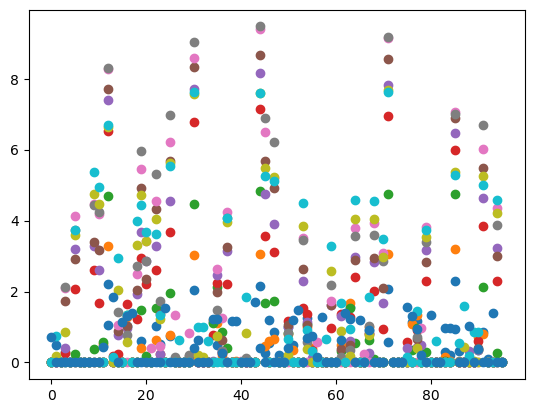

In [32]:
# Plot features for 11 patches
for i in range(11):
    plt.scatter(range(96), data_feats[i*10])
plt.show()

Try extracting mean features

In [33]:
mean_feats = extract_features_per_slide(tma_ids, train_df, patch_df, val_transform, 
                                           feature_model, mlp, device)

  0%|          | 0/25 [00:00<?, ?it/s]

In [34]:
np.array(mean_feats).shape

(25, 96)

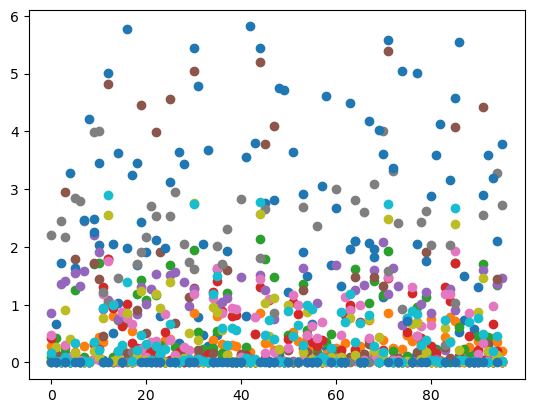

In [35]:
# Plot mean features for first 11 slides
for i in range(11):
    plt.scatter(range(96), mean_feats[i])
plt.show()

### Fit OneClassSVM

May have to fit on subsampled set of all data

In [36]:
def fit_ocsvm(data, nu):
    start = time.time()

    osvm = OneClassSVM(kernel='rbf',gamma='scale', nu=nu)
    osvm.fit(data)
    
    end = time.time()
    print(f'Took {end-start:.0f} seconds to fit OCSVM')
    
    return osvm

In [72]:
osvm = fit_ocsvm(data_feats, nu=0.16)

Took 0 seconds to fit OCSVM


In [73]:
np.unique(osvm.predict(data_feats), return_counts=True)

(array([-1,  1]), array([ 474, 2483]))

This is on patch level. In inference will fit on all patches of one slide at once. Then should roughly predict about 16% outliers per slide instead of across all slides.

#### Mean features OCSVM

Could take mean features over slides to correct.

In [74]:
mean_osvm = fit_ocsvm(mean_feats, nu=0.16)

Took 0 seconds to fit OCSVM


In [75]:
osvm_preds = mean_osvm.predict(mean_feats)
np.unique(osvm_preds, return_counts=True)

(array([-1,  1]), array([ 4, 21]))

If predicting one slide at once, using mean features, need to reshape data input

In [76]:
mean_osvm.predict(mean_feats[0].reshape(1, -1))[0]

-1

In [77]:
mean_feats[0].reshape(1, -1).shape

(1, 96)

Save model

In [41]:
def save_ocsvm(osvm, osvm_name):
    dump(osvm, f'{osvm_name}.joblib')

#### Check nu=0.16 model on other images

In [40]:
def test_ocsvm(osvm, train_ids=train_ids, train_df=train_df, patch_df=patch_df, val_transform=val_transform, 
              feature_model=feature_model, mlp=mlp, device=device):
    random.seed(1234)
    sample_ids = random.sample(list(train_ids), 30)
    
    test_mean_feats = extract_features_per_slide(sample_ids, train_df, patch_df, val_transform, 
                                           feature_model, mlp, device)
    osvm_preds = osvm.predict(test_mean_feats)
    print(np.unique(osvm_preds, return_counts=True))
    return test_mean_feats

In [83]:
test_mean_feats = test_ocsvm(osvm)

  0%|          | 0/30 [00:00<?, ?it/s]

(array([-1,  1]), array([ 1, 29]))


#### Test model with nu=0.84

Lots of outliers

In [87]:
mean_osvm = fit_ocsvm(mean_feats, nu=0.84)

Took 0 seconds to fit OCSVM


In [88]:
test_mean_feats = test_ocsvm(mean_osvm)

  0%|          | 0/30 [00:00<?, ?it/s]

(array([-1,  1]), array([23,  7]))


### Try linear SGD OCSVM

On mean slide features.

More consistent at predicting outliers.

In [37]:
def fit_sgd_ocsvm(data, nu):
    start = time.time()

    osvm = linear_model.SGDOneClassSVM(random_state=42, nu=nu)
    osvm.fit(data)
    
    end = time.time()
    print(f'Took {end-start:.0f} seconds to fit SGD OCSVM')
    
    return osvm

In [38]:
osvm = fit_sgd_ocsvm(mean_feats, nu=0.16)
np.unique(osvm.predict(mean_feats), return_counts=True)

Took 0 seconds to fit SGD OCSVM


(array([-1,  1], dtype=int32), array([ 1, 24]))

Correctly predicts most training data as non-outliers

In [42]:
test_mean_feats = test_ocsvm(osvm)

  0%|          | 0/30 [00:00<?, ?it/s]

(array([-1,  1], dtype=int32), array([ 2, 28]))


In [43]:
osvm_name = 'ocvsm_sgd_tma_mean_20x_nu_.16'
save_ocsvm(osvm, osvm_name)

### Fit SGD OCSVM on all TMA data feats

In [92]:
osvm = fit_sgd_ocsvm(data_feats, nu=0.16)

Took 0 seconds to fit SGD OCSVM


In [93]:
preds = osvm.predict(data_feats)
np.unique(preds, return_counts=True)

(array([-1,  1], dtype=int32), array([ 151, 2806]))

In [94]:
np.array(data_feats).shape

(2957, 96)

No outliers predicted in TMA set (all > 0)

In [95]:
for image_id in tma_patch_df.image_id.unique():
    image_idx = tma_patch_df.index[tma_patch_df.image_id==image_id].tolist()
    out_preds = preds[image_idx]
    out_pred = np.mean(out_preds)
    print(f'image id {image_id}, prediction {out_pred:.3f}')

image id 91, prediction 1.000
image id 4134, prediction 1.000
image id 8280, prediction 0.959
image id 9200, prediction 0.863
image id 13568, prediction 0.982
image id 17637, prediction 1.000
image id 21020, prediction 0.677
image id 29084, prediction 1.000
image id 31594, prediction 1.000
image id 35565, prediction 1.000
image id 36302, prediction 1.000
image id 36583, prediction 0.342
image id 36783, prediction 0.887
image id 37385, prediction 1.000
image id 40864, prediction 1.000
image id 41368, prediction 0.914
image id 41586, prediction 1.000
image id 42857, prediction 0.783
image id 44603, prediction 1.000
image id 47035, prediction 0.911
image id 48734, prediction 1.000
image id 50932, prediction 1.000
image id 53655, prediction 0.299
image id 57696, prediction 0.983
image id 61797, prediction 1.000


In [96]:
def test_no_mean_ocsvm(osvm, train_ids=train_ids, train_df=train_df, patch_df=patch_df, 
                       val_transform=val_transform, feature_model=feature_model, mlp=mlp, device=device):
    random.seed(1234)
    sample_ids = random.sample(list(train_ids), 10)
    osvm_preds = []
    
    for slide in sample_ids:
        
        slide_patch_df = patch_df[patch_df.image_id==slide].reset_index(drop=True)
        
        slide_patch_dataset = PatchDataset(patch_df=slide_patch_df, label_df=train_df, 
                                 image_folder=args.image_dir, transform=val_transform, return_id=True,
                                mag=args.mag)

        slide_data_loader = DataLoader(slide_patch_dataset, batch_size=args.batch_size_per_gpu, 
                             shuffle=False, num_workers=args.num_workers, pin_memory=True, sampler=None)
        
        slide_feats = extract_features(feature_model, mlp, slide_data_loader, device)
    
        osvm_all_preds = osvm.predict(slide_feats)
        osvm_pred = np.mean(osvm_all_preds)
        print(f'Image {slide}, prediction {osvm_pred:.2f}')
        osvm_preds.append(1 if osvm_pred >= 0 else -1)
    
    #print(np.unique(osvm_preds, return_counts=True))
    print('Predictions:', osvm_preds)
    return osvm_preds

#### If mean prediction < 0, mark as outlier

In [97]:
osvm_preds = test_no_mean_ocsvm(osvm)

Evaluating:   0%|          | 0/11 [00:00<?, ?it/s]

Image 56843, prediction 0.95


Evaluating:   0%|          | 0/48 [00:00<?, ?it/s]

Image 15188, prediction 0.67


Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Image 1020, prediction 0.85


Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Image 10800, prediction 0.74


Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Image 3997, prediction 0.92


Evaluating:   0%|          | 0/33 [00:00<?, ?it/s]

Image 10077, prediction 0.56


Evaluating:   0%|          | 0/17 [00:00<?, ?it/s]

Image 12222, prediction 0.31


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Image 45254, prediction 0.71


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Image 30539, prediction 0.82


Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Image 1943, prediction 0.60
Predictions: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## Sample 200 patches from full dataset and train SVM on these

In [44]:
# Have to sample with replacement because some images don't have 200 patches
sampled_patch_df = patch_df.groupby("image_id").sample(200, replace=True).reset_index(drop=True)

In [45]:
patch_dataset = PatchDataset(patch_df=sampled_patch_df, label_df=train_df, 
                                 image_folder=args.image_dir, transform=val_transform, return_id=True,
                                mag=args.mag)

data_loader = DataLoader(patch_dataset, batch_size=args.batch_size_per_gpu, 
                             shuffle=False, num_workers=args.num_workers, pin_memory=True, sampler=None)
samp_data_feats = extract_features(feature_model, mlp, data_loader, device)

Evaluating:   0%|          | 0/53 [00:00<?, ?it/s]

#### nu = 0.5

2 outliers predicted in 25 TMAs

In [100]:
osvm = fit_sgd_ocsvm(samp_data_feats, nu=0.5)

Took 1 seconds to fit SGD OCSVM


In [101]:
# Predict on TMAs
preds = osvm.predict(data_feats)
np.unique(preds, return_counts=True)

(array([-1,  1], dtype=int32), array([ 377, 2580]))

In [102]:
for image_id in tma_patch_df.image_id.unique():
    image_idx = tma_patch_df.index[tma_patch_df.image_id==image_id].tolist()
    out_preds = preds[image_idx]
    out_pred = np.mean(out_preds)
    print(f'image id {image_id}, prediction {out_pred:.3f}')

image id 91, prediction 1.000
image id 4134, prediction 0.577
image id 8280, prediction 0.876
image id 9200, prediction 0.573
image id 13568, prediction 0.893
image id 17637, prediction 1.000
image id 21020, prediction 0.077
image id 29084, prediction 1.000
image id 31594, prediction 1.000
image id 35565, prediction 1.000
image id 36302, prediction 1.000
image id 36583, prediction -0.219
image id 36783, prediction 0.623
image id 37385, prediction 1.000
image id 40864, prediction 0.908
image id 41368, prediction 0.865
image id 41586, prediction 1.000
image id 42857, prediction 0.478
image id 44603, prediction 1.000
image id 47035, prediction 0.356
image id 48734, prediction 0.984
image id 50932, prediction 1.000
image id 53655, prediction -0.282
image id 57696, prediction 0.983
image id 61797, prediction 1.000


#### nu = 0.86

3 outliers predicted in 25 TMAs

In [107]:
osvm = fit_sgd_ocsvm(samp_data_feats, nu=0.86)

Took 0 seconds to fit SGD OCSVM


In [108]:
# Predict on TMAs
preds = osvm.predict(data_feats)
np.unique(preds, return_counts=True)

(array([-1,  1], dtype=int32), array([ 526, 2431]))

In [109]:
for image_id in tma_patch_df.image_id.unique():
    image_idx = tma_patch_df.index[tma_patch_df.image_id==image_id].tolist()
    out_preds = preds[image_idx]
    out_pred = np.mean(out_preds)
    print(f'image id {image_id}, prediction {out_pred:.3f}')

image id 91, prediction 1.000
image id 4134, prediction 0.154
image id 8280, prediction 0.773
image id 9200, prediction 0.368
image id 13568, prediction 0.750
image id 17637, prediction 0.983
image id 21020, prediction -0.092
image id 29084, prediction 1.000
image id 31594, prediction 0.927
image id 35565, prediction 0.939
image id 36302, prediction 1.000
image id 36583, prediction -0.438
image id 36783, prediction 0.245
image id 37385, prediction 0.964
image id 40864, prediction 0.832
image id 41368, prediction 0.791
image id 41586, prediction 0.960
image id 42857, prediction 0.304
image id 44603, prediction 0.987
image id 47035, prediction 0.156
image id 48734, prediction 0.953
image id 50932, prediction 1.000
image id 53655, prediction -0.590
image id 57696, prediction 0.983
image id 61797, prediction 0.987


#### nu = 0.16

No outliers predicted in 25 TMAs

In [46]:
osvm = fit_sgd_ocsvm(samp_data_feats, nu=0.16)

Took 1 seconds to fit SGD OCSVM


In [47]:
np.array(samp_data_feats).shape

(107600, 96)

In [48]:
# Predict on TMAs
preds = osvm.predict(data_feats)
np.unique(preds, return_counts=True)

(array([-1,  1], dtype=int32), array([ 379, 2578]))

In [49]:
for image_id in tma_patch_df.image_id.unique():
    image_idx = tma_patch_df.index[tma_patch_df.image_id==image_id].tolist()
    out_preds = preds[image_idx]
    out_pred = np.mean(out_preds)
    print(f'image id {image_id}, prediction {out_pred:.3f}')

image id 91, prediction 1.000
image id 4134, prediction 0.365
image id 8280, prediction 0.918
image id 9200, prediction 0.607
image id 13568, prediction 0.946
image id 17637, prediction 1.000
image id 21020, prediction 0.185
image id 29084, prediction 1.000
image id 31594, prediction 1.000
image id 35565, prediction 0.798
image id 36302, prediction 1.000
image id 36583, prediction 0.000
image id 36783, prediction 0.698
image id 37385, prediction 0.964
image id 40864, prediction 0.939
image id 41368, prediction 0.816
image id 41586, prediction 0.980
image id 42857, prediction 0.435
image id 44603, prediction 0.973
image id 47035, prediction 0.400
image id 48734, prediction 1.000
image id 50932, prediction 1.000
image id 53655, prediction -0.402
image id 57696, prediction 0.983
image id 61797, prediction 1.000


In [50]:
osvm_name = 'ocvsm_sgd_samp200_20x_nu_.16'
save_ocsvm(osvm, osvm_name)